<a href="https://colab.research.google.com/github/grgrbu/ML-bioinf/blob/main/HW6_NB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
import scipy.stats
import nltk
from collections import Counter

In [2]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [3]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [4]:
X, y = read_dataset("./spam")

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [6]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
    
    def fit(self, X, y):
        self.classes, self.count_classes = np.unique(y, return_counts=True)
        self.f_probs = self.count_classes / len(y)
        self.s_probs = []

        xiyi = []
        for i in range(len(self.classes)):
          xiyi.append(X[y == self.classes[i]])
        
        for i in range(len(xiyi)):
          num = np.sum(xiyi[i], axis = 0) + self.alpha
          den = np.sum(xiyi[i]) + self.alpha * xiyi[i].shape[1]
          self.s_probs.append(num / den)

        
    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
      log = []
      for i in range(len(X)):
        log.append([0] * len(self.classes))
        for j in range(len(self.classes)):
          log[i][j] = scipy.stats.multinomial(X[i].sum(), self.s_probs[j]).logpmf(X[i]) + np.log(self.f_probs[j])
      return log

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [7]:
print(X_train)

['Yeah if we do have to get a random dude we need to change our info sheets to PARTY  &lt;#&gt; /7 NEVER STUDY just to be safe'
 'Hey whats up? U sleeping all morning?'
 "Yes i have. So that's why u texted. Pshew...missing you so much" ...
 'I like to talk pa but am not able to. I dont know y.'
 'is your hamster dead? Hey so tmr i meet you at 1pm orchard mrt? '
 'WINNER! As a valued network customer you hvae been selected to receive a £900 reward! To collect call 09061701444. Valid 24 hours only. ACL03530150PM']


In [8]:
class BoW:
    def __init__(self, X, voc_limit=1000):
      self.voc_limit = voc_limit
      words = dict()
      for i in range(len(X)):
        # s = X[i].split(" ,;!@#$%^&*()_+=-/'].;[,>:{?}")
        s = re.sub("[^\w\s]", "", X[i]).split()
        for word in s:
          if word != "" and word in words.keys():
            words[word] += 1
          elif word != "":
            words[word] = 1
      words_count = []
      for key in words.keys():
        words_count.append((-words[key], key))
      words_count.sort()
      self.words = dict()
      for i in range(voc_limit):
        self.words[words_count[i][1]] = i
        
    def transform(self, X):
        new_X = []
        for i in range(len(X)):
          # s = X[i].split(" ,;!@#$%^&*()_+=-/'].;[,>:{?}")
          s = re.sub("[^\w\s]", "", X[i]).split()
          new_X.append([0] * self.voc_limit)
          for word in s:
            if word in self.words.keys():
              new_X[i][self.words[word]] += 1
        new_X = np.array(new_X)
        return new_X

In [9]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [10]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9872068230277186, 'spam': 0.9325842696629213},
 {'ham': 0.9872068230277186, 'spam': 0.9325842696629213},
 0.978494623655914)

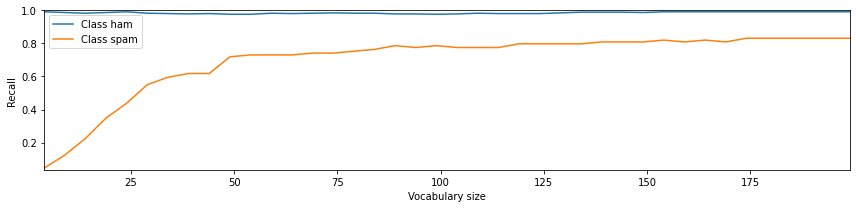

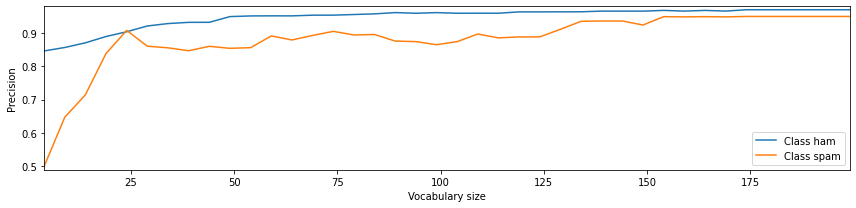

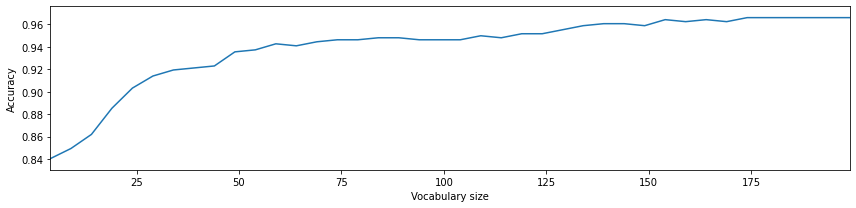

In [11]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [16]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
      self.stemmer = SnowballStemmer('english')
      self.voc_limit = voc_limit
      words = dict()
      for i in range(len(X)):
        # s = X[i].split(" ,;!@#$%^&*()_+=-/'].;[,>:{?}")
        s = re.sub("[^\w\s]", "", X[i]).split()
        for w in s:
          word = self.stemmer.stem(w)
          if word != "" and word in words.keys():
            words[word] += 1
          elif word != "":
            words[word] = 1
      words_count = []
      for key in words.keys():
        words_count.append((-words[key], key))
      words_count.sort()
      self.words = dict()
      for i in range(voc_limit):
        self.words[words_count[i][1]] = i
        
    def transform(self, X):
        new_X = []
        for i in range(len(X)):
          # s = X[i].split(" ,;!@#$%^&*()_+=-/'].;[,>:{?}")
          s = re.sub("[^\w\s]", "", X[i]).split()
          new_X.append([0] * self.voc_limit)
          for w in s:
            word = self.stemmer.stem(w)
            if word in self.words.keys():
              new_X[i][self.words[word]] += 1
        new_X = np.array(new_X)
        return new_X

In [17]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [18]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9809322033898306, 'spam': 0.9302325581395349},
 {'ham': 0.9872068230277186, 'spam': 0.898876404494382},
 0.9731182795698925)

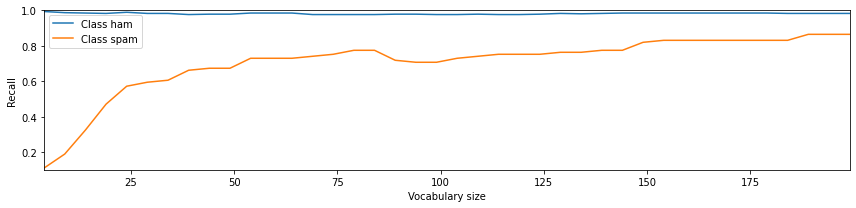

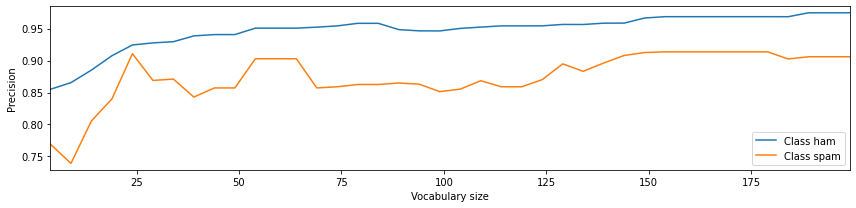

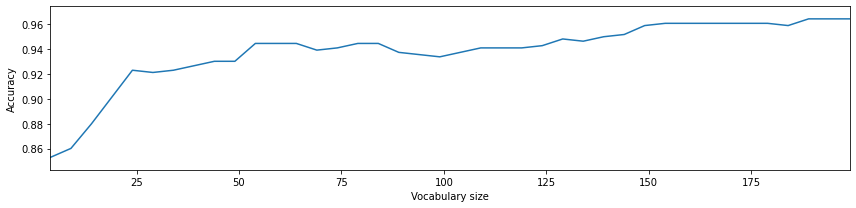

In [19]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)